In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ㄱ/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/ㄱ/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ㄱ/test.csv')

# GPU

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# installing Transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 34.6 MB/s 
     |████████████████████████████████| 163 kB 73.7 MB/s 
     |████████████████████████████████| 7.6 MB 70.3 MB/s 


# Parsing the dataset
### 판다스 사용해서 train 데이터를 구문 분석하고 속성 및 데이터 포인트 살펴보기

In [ ]:
#grammar data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['cohesion','syntax','vocabulary','phraseology','conventions'], inplace=True, axis=1)

In [ ]:
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

Number of trainig sentences: 3,911



,text_id,full_text,grammar
1082,52DC3B7C3952,Working From Home\n\nShould students be allowe...,5.0
3411,EA42A6028804,People argue whether or not its a good idea fo...,3.0
1909,8FF22F2804A3,A city council is debating the adoption of a 1...,2.0
3801,FB4D3D883D49,Cellphones has already taken place of your cal...,2.0
257,12CA89146E91,It is true that your character will be what yo...,2.5
277,144671E445D0,A British naturalist and politician John Lubbo...,2.5
2848,CEF302996231,"Dear Dr. Generic_Name,\n\nThank you for taking...",3.0
3579,F1CB29904BBD,My dad is someone who has shared wisdom and ex...,2.5
3826,FC831CB27E25,"Although some people might say, if the student...",2.5
1990,9685DD18847A,Some students don't have an idea of what caree...,3.0


문법의 점수를 예측할 것이기 때문에 full_tex와 grammar만 남겨둠

훈련 세트의 문장과 레이블을 numpy ndarray로 추출

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.grammar.values

# Bert Tokenizer

### Bert에 텍스트를 넣으려면 토큰으로 분할되어야 하고, 그런 다음 토큰을 토크나이저 어휘의 인덱스에 매핑해야 함.

#### Tokenization(토큰화)는 BERT에 포함된 토크나이저에서 수행함. +"uncased" 버전 사용

In [ ]:
from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

Loading Bert Tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 한 문장에 토크나이저 적용 해보기

In [ ]:
# 오리지널 문장
print('Original : ', full_text[0])
# 토큰으로 분할 된 문장
print('Tokenized : ',tokenizer.tokenize(full_text[0]))
# token ids에 매핑된 문장
# input_ids는 문장의 각 토큰에 해당하는 인덱스입니다.
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(full_text[0])))

Original :  I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.

The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.

most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up a

# Tokenize the dataset

### Encode_plus 가 하는 일:
1. 문장 토크나이즈
2. 시작 부분에 [CLS]토큰 추가
3. 끝 부분에 [SEP] 토큰 추가
4. 토큰에 ID 매핑
5. 문장을 'max_length'로 채우거나 자른다.
6. [PAD]토큰에 대한 attention mask 생성

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 320, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.

The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.

most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up an

# Training & Validation Split
### training 90% 사용하고 validation에 10%를 사용하도록 training set를 나눈다

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,519 training samples
  392 validation samples


torch DataLoader 클래스를 사용하여 데이터 세트에 대한 iterator를 생성한다. for 루프와 달리 iterator를 사용하면 전체 데이터 세트를 메모리에 로드할 필요가 없기 때문에 이는 훈련 중에 메모리를 절약하는 데 도움이 된다.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#DataLoader는 훈련을 위한 배치크기를 알아야 하므로 지정함.
#Bert를 미세조정하기 위해 배치 사이즈 16/32 권장
batch_size = 14

#training, validation 세트에 대한 DataLoader를 생성
#무작위 순서로 학습 샘플을 가져옴.
train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

#validation에서 순서가 중요하지 않아서 순서대로 진행함
valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

# Train Model
## BertForSequencClassification
#### pre-trained된 bert 모델을 수정하여 분류를 위한 출력을 제공
#### 전체 모델이 우리 task에 적합할 때까지 데이터 세트에서 모델을 계속 훈련

#### <b>BertForSequenceClassification</b>은 분류를 위해 단일 선형 레이어가 추가된 일반 Bert 모델임
#### 입력 데이터를 넣을 때 pre trained된 bert 모델과 추가 훈련되지 않은 분류 계층이 특정 task에 대해 훈련됨

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, #출력 레이블 수 (2진 분류의 경우 2)
        # grammar 점수가 9개라 9개 적음
        # 다중 클래스 작업의 경우 이 값을 늘릴 수 있다.
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)
# GPU에서 이 모델을 실행하도록 pytorch에 지시
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

아래의 셀에는 가중치의 이름과 dimesions 출력
1. The embedding layer
2. The first of the twelve transformers
3. The Output layer

In [ ]:
# 모델의 모든 parameters를 튜플 목록으로 가져옴.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55}{:12}".format(p[0], str(tuple(p[1].size()))))
    
print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:55}{:12}".format(p[0], str(tuple(p[1].size()))))
    
print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:55}{:12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                 (30522, 768)
bert.embeddings.position_embeddings.weight             (512, 768)  
bert.embeddings.token_type_embeddings.weight           (2, 768)    
bert.embeddings.LayerNorm.weight                       (768,)      
bert.embeddings.LayerNorm.bias                         (768,)      

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight       (768, 768)  
bert.encoder.layer.0.attention.self.query.bias         (768,)      
bert.encoder.layer.0.attention.self.key.weight         (768, 768)  
bert.encoder.layer.0.attention.self.key.bias           (768,)      
bert.encoder.layer.0.attention.self.value.weight       (768, 768)  
bert.encoder.layer.0.attention.self.value.bias         (768,)      
bert.encoder.layer.0.attention.output.dense.weight     (768, 768)  
bert.encoder.layer.0.attention.output.dense.bias       (768,)      
bert.en

# Optimizer & Learning Rate Scheduler
### 이제 모델이 로드되었으므로 저장된 모델 내에서 훈련 하이퍼파라미터를 가져와야 함

### fine-tuning을 위해서 다음 값 중에서 선택하는 것이 좋다
- Batch size : 16, 32
- Learnin rate(Adam) : 5e-5, 3e-5, 2e-5
- number of epochs: 2,3,4

여기서는:
- Batch size : 32 (이미 DataLoaders에서 선택함)
- Learning rate : 2e-5
- epochs : 4 (너무 많은 것 같은데..)

Epsilon parameter <b>eps= 1e-8</b>은 구현에서 0으로 나누는 것을 방지하기 위한 매우 작은 숫자임

run_glue.py에서 AdamW optimizer의 생성을 찾을 수 있다.

In [ ]:
# 참고 : AdamW는 hugging face 라이브러리의 클래스임(pytorch와 반대)
# W = Weight Dacay Fix?
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. 2-4사이 권장
# 4를 선택하지만 과적합될수있음
epochs = 10
# 총 훈련 단계 수는 [배치 수] X [에포크 수]
# (훈련 샘플의 수와 동일하지 않음)
total_steps = len(train_dataloader) * epochs

# learning rate scheduler 만들기
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

# Training Model
### 정확도 계산을 위한 helper function 정의

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#### 경과 시간을 hh:mm:ss 형식으로 지정하는 helper function

In [ ]:
import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### ㄷㄱㄷㄱ 훈련 시작 준비 완료

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


=======Epoch 1 / 10 =======
Training...
 Batch    40 of   252. Elapsed: 0:00:34
 Batch    80 of   252. Elapsed: 0:01:06
 Batch   120 of   252. Elapsed: 0:01:40
 Batch   160 of   252. Elapsed: 0:02:14
 Batch   200 of   252. Elapsed: 0:02:48
 Batch   240 of   252. Elapsed: 0:03:22

  Average training loss: 0.71
  Training epoch took: 0:03:32

Running Validation...
  Accuracy: 0.00
  Validation Loss: 0.25
  Validation took: 0:00:09

=======Epoch 2 / 10 =======
Training...
 Batch    40 of   252. Elapsed: 0:00:34
 Batch    80 of   252. Elapsed: 0:01:08
 Batch   120 of   252. Elapsed: 0:01:42
 Batch   160 of   252. Elapsed: 0:02:17
 Batch   200 of   252. Elapsed: 0:02:51
 Batch   240 of   252. Elapsed: 0:03:25

  Average training loss: 0.27
  Training epoch took: 0:03:35

Running Validation...
  Accuracy: 0.00
  Validation Loss: 0.43
  Validation took: 0:00:09

=======Epoch 3 / 10 =======
Training...
 Batch    40 of   252. Elapsed: 0:00:34
 Batch    80 of   252. Elapsed: 0:01:08
 Batch   12

In [ ]:
import pandas as pd

#소수점 이하 두 자리로 부동 소수점을 표시
df_stats = pd.DataFrame(data=training_stats)

#row index로 'epoch'사용
df_stats = df_stats.set_index('epoch')

#column 헤더를 강제로 wrap

#display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.708669,0.253903,0.0,0:03:32,0:00:09
2,0.265718,0.434804,0.0,0:03:35,0:00:09
3,0.210068,0.475172,0.0,0:03:34,0:00:09
4,0.147618,0.264418,0.0,0:03:34,0:00:09
5,0.094637,0.393285,0.0,0:03:34,0:00:09
6,0.069689,0.371532,0.0,0:03:34,0:00:09
7,0.049742,0.293220,0.0,0:03:35,0:00:09
8,0.038470,0.303034,0.0,0:03:35,0:00:09
9,0.032195,0.304928,0.0,0:03:34,0:00:09


각 epoch 따라 training loss가 감소하고 valid loss 감소

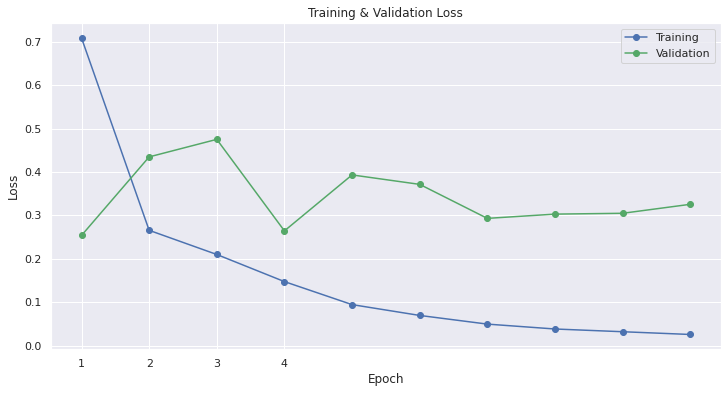

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance of Test Set

## Data Preparation
#### text data set를 준비하기 위해 train data에 대해 했던 것과 동일한 단계를 모두 적용해야 한다.

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['cohesion','syntax','vocabulary','phraseology','conventions'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

,text_id,full_text,grammar
0,0000C359D63E,when a person has no experience on a job their...,3.0
1,000BAD50D026,Do you think students would benefit from being...,3.0
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.0


In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.grammar.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 3



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Evaluate on Test Set

### 테스트 세트가 준비되면 fine-tuning된 모델을 적용하여 테스트 세트에 대한 예측을 생성할 수 있음

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

Prediction labels for 3 test sentences...
    완료. 
[array([[2.6528852],
       [2.2039738],
       [3.833632 ]], dtype=float32)]
[array([3., 3., 3.])]


In [ ]:
grammar_submission = predictions[0]

In [ ]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

# 2. Cohesion

In [ ]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

FileNotFoundError: ignored

In [ ]:
#cohesion data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['grammar','syntax','vocabulary','phraseology','conventions'], inplace=True, axis=1)

In [ ]:
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.cohesion.values

In [ ]:
from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#DataLoader는 훈련을 위한 배치크기를 알아야 하므로 지정함.
#Bert를 미세조정하기 위해 배치 사이즈 16/32 권장
batch_size = 16

#training, validation 세트에 대한 DataLoader를 생성
#무작위 순서로 학습 샘플을 가져옴.
train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

#validation에서 순서가 중요하지 않아서 순서대로 진행함
valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, #출력 레이블 수 (2진 분류의 경우 2)
        # grammar 점수가 9개라 9개 적음
        # 다중 클래스 작업의 경우 이 값을 늘릴 수 있다.
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)
# GPU에서 이 모델을 실행하도록 pytorch에 지시
model.cuda()

In [ ]:
# 모델의 모든 parameters를 튜플 목록으로 가져옴.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55}{:12}".format(p[0], str(tuple(p[1].size()))))
    
print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:55}{:12}".format(p[0], str(tuple(p[1].size()))))
    
print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:55}{:12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
# 참고 : AdamW는 hugging face 라이브러리의 클래스임(pytorch와 반대)
# W = Weight Dacay Fix?
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
# 총 훈련 단계 수는 [배치 수] X [에포크 수]
# (훈련 샘플의 수와 동일하지 않음)
total_steps = len(train_dataloader) * epochs

# learning rate scheduler 만들기
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['grammar','syntax','vocabulary','phraseology','conventions'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.cohesion.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

In [ ]:
cohesion_submission = predictions[0]

# 3. Syntax

In [ ]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
#cohesion data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['cohesion','grammar','vocabulary','phraseology','conventions'], inplace=True, axis=1)
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.syntax.values

from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, 
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)

model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['grammar','cohesion','vocabulary','phraseology','conventions'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.syntax.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

In [ ]:
syntax_submission = predictions[0]

# 4. Vocabulary

In [ ]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
#cohesion data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['cohesion','grammar','syntax','phraseology','conventions'], inplace=True, axis=1)
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.vocabulary.values

from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, 
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)

model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['grammar','cohesion','syntax','phraseology','conventions'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.vocabulary.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

In [ ]:
vocab_submission = predictions[0]

# 5. phraseology

In [ ]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
#cohesion data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['cohesion','grammar','syntax','vocabulary','conventions'], inplace=True, axis=1)
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.phraseology.values

from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, 
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)

model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['grammar','cohesion','syntax','vocabulary','conventions'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.phraseology.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

In [ ]:
phrase_submission = predictions[0]

# 6. Conventions

In [ ]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
#cohesion data만 사용하기 위해서 나머지 평가항목 컬럼은 드롭
train.drop(['cohesion','grammar','syntax','vocabulary','phraseology'], inplace=True, axis=1)
print('Number of trainig sentences: {:,}\n'.format(train.shape[0]))
train.sample(10)

In [ ]:
# Get the lists of sentences and their labels.
full_text = train.full_text.values
labels = train.conventions.values

from transformers import BertTokenizer

print("Loading Bert Tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# 모든 문장을 토큰화하고 토큰을 해당 단어 ID에 매핑
input_ids = []
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    # 'max_length'의 숫자는 어떻게 정하는 거지?
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    # 인코딩된 문장을 목록에 추가
    input_ids.append(encoded_dict['input_ids'])
    
    # Attention mask
    attention_masks.append(encoded_dict['attention_mask'])
    
# 목록을 텐서로 변환
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# full_text 첫번째 문장을 IDs의 리스트로 출력해보기
print('Original: ', full_text[0])
print('Token IDs: ', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
# training inputs을 TensorDataset에 결합
dataset = TensorDataset(input_ids, attention_masks, labels)

#90-10 train-validation split.
#각 세트에 포함할 샘플 수를 계산
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

#무작위로 샘플을 선택하여 데이터 세트를 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset, # training sample
            sampler = RandomSampler(train_dataset), #배치를 랜덤으로 선택
            batch_size = batch_size #훈련을 이 배치 사이즈로 함.
        )

valid_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset), # 배치를 순차적으로 꺼냄.
                batch_size = batch_size #이 배치 사이즈로 평가하기
        )

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # 12레이어 버트 모델 사용 (uncased)
        num_labels = 1, 
        output_attentions = False, #모델이 attention 가중치를 리턴하는지
        output_hidden_states = False, #모델이 hidden states를 리턴하는지
        #attention_probs_dropout_prob=0.4,
        #hidden_dropout_prob=0.4,
)

model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5, #arg.learning_rate - 기본값은 5e-5이고 노트북에는 2e-5가 있다.
                 eps = 1e-8) #arg.adam_epsilon - 기본값은 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [ ]:
import numpy as np

# 예측 vs 레이블의 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    #가까운 초로 반올림
    elapsed_rounded = int(round((elapsed)))
    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

#모든 곳에 seed 값을 설정하기
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training , validation loss 같은 많은 수량을 저장
# validation accuracy, and timings.
training_stats = []

# 전체 실행에 대한 총 훈련시간을 측정함
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('=======Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print("Training...")
    
    # training epoch가 걸리는 시간을 측정
    t0 =time.time()
    
    # epoch의 전체 loss를 재설정
    total_train_loss = 0
    
    # 모델을 학습 모드로 전환 
    # train은 *모드*를 변경할 뿐 훈련을 *수행*하지 않음.
    # 'dropoout' / 'batchnorm' 레이어는 훈련 중에 다르게 작동함
    model.train()
    
    # 훈련 데이터의 각 batch에 대해
    for step, batch in enumerate(train_dataloader):
        #40개 batch마다 진행률이 업데이트됨
        if step % 40 == 0 and not step == 0:
            #경과시간을 분 단위로 계산함
            elapsed = format_time(time.time()-t0)
            #진행상황 보고
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
    
        #DataLoader에서 훈련 batch의 압축을 푼다
        #Batch의 압축을 풀면서 각 텐서를 사용하여 GPU에 복사함
        # 'to' method

        #'batch'에는 세 개의 pytorch 텐서가 포함되어 있음.
        # input ids
        # attention masks
        # labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)

        # 모델 훈련을 수행하기 이전에 계산된 gradient는 지워야 함
        # backward pass : pytorch는 이 작업을 자동으로 수행하지 않는다.
        # gradient를 누적하는 것은 RNN을 훈련하는 동안 편리함
        model.zero_grad()
    
        # forward pass 수행 (정방향 전달)
        # 어떤 arguments에 따라 다른 수의 parameter를 return
        # arguments가 주어지고 flags가 설정됨
        # loss (label를 주었기 때문에) logits model
        # activation 전 출력
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=False)
    
        #모든 Batch에 대한 훈련 loss를 누적하여 다음을 수행할 수 있다.
        # 마지막에 평균 loss를 계산함 loss는 다음을 포함하는 텐서이다.
        # single value; .item() function은 python 값을 return
        #print(loss.item(), type(loss.item()))
        total_train_loss += loss.item()

        # backward pass로 gradients를 계산함
        loss.backward()
    
        # gradient 표준을 1.0으로 자름
        # "exploding gradients"문제에도 도움이 됨
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        # Optimizer는 "업데이트 rule"(parameter가 어떻게 학습률과 기울기에 따라 수정되는지)지시
        optimizer.step()
        
        #update the learnin rate.
        scheduler.step()
    
    # 모든 batch에 대한 평균 손실을 계산함
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 이 에포크가 얼마나 걸렸는지 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # ======validation======
    #각 training epoch를 완료 후 성능을 측정함
    # VALIDATION SET
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # 모델을 평가 모드에. dropout layer가 다르게 작동함
    model.eval()
    
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    #Evaluate data for one epoch
    for batch in valid_dataloader:
        #DataLoader에서 training batch 압축 해제
        #batch의 압축을 풀면서 각 텐서를 GPU에 복사
        #"to"method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device, dtype=torch.float32)
        
        #pytorch에게 compute 그래프를 구성하는동안 귀찮게 하지 말라고 하기
        #forward pass ; backprop (역전파) training에만 필요
        with torch.no_grad():
            
            #forward pass : logit predictions를 계산
            #token_type_ids는 "segment ids"와 동일
            # 2문장 작업에서 문장 1과 2를 구별
            
            #모델의 logits의 출력을 가져옴. 
            #softmax 함수를 적용하기 전 값
            (loss, logits) = model(b_input_ids,
                                  token_type_ids=None,
                                  attention_mask=b_input_mask,
                                  labels=b_labels,
                                  return_dict=False)
        #validation loss를 누적
        total_eval_loss += loss.item()
        
        #logits, labels 는 CPU로 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # test 문장 batch 정확도를 계산하고 모든 batch에 누적함
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # validation 실행에 대한 최종 정확도를 보고함.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    #모든 배치에 대한 평균 loss를 계산
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    #validation실행에 걸린 시간을 측정
    validation_time = format_time(time.time()-t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # epoch의 모든 통계를 기록
    training_stats.append(
        {
            'epoch': epoch_i+1,
            'Training Loss' : avg_train_loss,
            'Valid. Loss' : avg_val_loss,
            'Valid. Accur.' : avg_val_accuracy,
            'Training Time' : training_time,
            'Validation Time' : validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_INNER_JOIN = pd.merge(test, submission, left_on='text_id', right_on='text_id', how='inner')
df_INNER_JOIN.drop(['grammar','cohesion','syntax','vocabulary','phraseology'], inplace=True, axis=1)
labels = df_INNER_JOIN
labels

In [ ]:
import pandas as pd
#test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

#문장 수
print('Number of test sentences: {:,}\n'.format(labels.shape[0]))

#리스트 만들기
full_text = labels.full_text.values
labels = labels.conventions.values

#모든 문장을 토큰화하고 토큰을 해당 단어 IDs에 매핑한다.
input_ids=[]
attention_masks = []

for text in full_text:
    encoded_dict = tokenizer.encode_plus(
                    text,#문장을 encode
                    add_special_tokens = True, #[CLS][SEP]토큰 추가
                    max_length = 256, #모든 문장 자르고 채우기 
                    truncation=True,
                    pad_to_max_length = True,
                    return_attention_mask = True,#Attention mask 만들기
                    return_tensors = 'pt' #파이토치 텐서로 리턴
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# 테스트 셋 예측
print('Prediction labels for {:,} test sentences...'.format(len(input_ids)))

# put model in evaluation mode
model.eval()

#Tracking Variables
predictions, true_labels = [], []

#predict
for batch in prediction_dataloader:
    #GPU에 Batch 넣기
    batch= tuple(t.to(device) for t in batch)
    
    #DataLoader에서 input 압축풀기
    b_input_ids, b_input_mask, b_labels = batch
    
    #모델에 기울기를 계산하거나 저장하지 않도록 지시하여 메모리를 절약하고
    #예측속도향상
    with torch.no_grad():
        #Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
    logits = outputs[0]
    
    #Logits, labels를 cpu로 옮기기
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('    완료. ')
print(predictions)
print(true_labels)

In [ ]:
convent_submission = predictions[0]

In [ ]:
submission.cohesion = cohesion_submission
submission.grammar = grammar_submission
submission.syntax = syntax_submission
submission.vocabulary = vocab_submission
submission.phraseology = phrase_submission
submission.conventions = convent_submission

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv',index=False)
submission = pd.read_csv('submission.csv')
submission